<a href="https://colab.research.google.com/github/hadeelfarash/INTERMEDIATE_MACHINE_LEARNING/blob/main/PCA_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute  import SimpleImputer

pd.set_option("display.max_columns",200)
pd.set_option("display.max_info_rows",800)
pd.set_option("display.max_info_columns",800)

from sklearn import set_config
set_config(transform_output= "pandas")

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

## Load the Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week17/Data/NHANES_Diet_Diabetes_Risk.xls.csv")
df.head()

,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,Diabetes_Risk
0,73557,16888.32786,12930.89065,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,3.0,2.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.0,70.0,110.0,60.0,304.0,278.0,1398.0,430.0,1.057,1.216,11.804,0.951,285.0,66.0,219.0,330.0,216.3,2.79,0.00,241.4,3.3,29.2,949.0,756.0,206.0,8.41,8.85,1.072,1323.0,2228.0,62.5,203.0,36.0,0.0,2701.79,0.219,0.099,0.103,0.153,0.346,1.221,9.694,5.408,1.173,16.796,0.121,0.001,7.932,0.769,0.000,0.094,0.001,0.000,0.010,2.0,960.0,960.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,73558,17932.14387,12684.14887,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,53.408,35.481,20.505,2584.0,20.94,0.0,1477.0,1488.0,0.0,145.0,12.0,0.0,899.0,4.178,5.168,65.396,4.415,1243.0,601.0,641.0,1662.0,2149.0,21.45,0.00,2.3,15.2,23.4,3193.0,6427.0,903.0,26.88,30.36,4.130,9726.0,4930.0,715.8,240.0,0.0,119.0,6779.99,1.872,1.160,0.802,1.286,1.297,6.516,27.952,12.107,2.208,32.429,0.086,0.000,15.483,1.774,0.007,0.728,1.003,0.104,1.139,2.0,360.0,360.0,0.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2
2,73559,59641.81293,39394.23671,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.263,20.902,12.953,88.0,8.87,0.0,616.0,655.0,21.0,449.0,35.0,515.0,300.0,1.648,1.747,18.342,1.906,423.0,290.0,133.0,625.0,161.2,3.78,1.42,195.1,4.0,40.4,877.0,1198.0,210.0,17.57,8.98,0.949,2943.0,1694.0,98.3,45.0,71.0,0.0,3766.70,0.358,0.128,0.371,0.455,3.008,2.067,10.691,7.497,0.531,19.910,0.164,0.005,11.705,1.092,0.000,0.042,0.001,0.006,0.002,2.0,1254.0,0.0,1254.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,73561,59052.35703,39004.89299,1,63.0,2.0,2.0,18.0,1.0,1.0,1.0,13.0,4.0,Na

In [ ]:
# df.drop(columns=['DRQSDT5'], inplace=True)


## Preprocess the Data
Set SEQN as the index
//Train Test Split
//Impute Missing Values with the median value
//Scale

In [ ]:
df = df.set_index("SEQN")
df

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,Diabetes_Risk
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73557,16888.32786,12930.890650,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,3.0,2.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.00,70.0,110.0,60.0,304.0,278.0,1398.0,430.0,1.057,1.216,11.804,0.951,285.0,66.0,219.0,330.0,216.3,2.79,0.00,241.4,3.3,29.2,949.0,756.0,206.0,8.41,8.85,1.072,1323.0,2228.0,62.5,203.0,36.0,0.0,2701.79,0.219,0.099,0.103,0.153,0.346,1.221,9.694,5.408,1.173,16.796,0.121,0.001,7.932,0.769,0.000,0.094,0.001,0.000,0.010,2.0,960.0,960.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
73558,17932.14387,12684.148870,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,53.408,35.481,20.505,2584.0,20.94,0.00,1477.0,1488.0,0.0,145.0,12.0,0.0,899.0,4.178,5.168,65.396,4.415,1243.0,601.0,641.0,1662.0,2149.0,21.45,0.00,2.3,15.2,23.4,3193.0,6427.0,903.0,26.88,30.36,4.130,9726.0,4930.0,715.8,240.0,0.0,119.0,6779.99,1.872,1.160,0.802,1.286,1.297,6.516,27.952,12.107,2.208,32.429,0.086,0.000,15.483,1.774,0.007,0.728,1.003,0.104,1.139,2.0,360.0,360.0,0.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2
73559,59641.81293,39394.236710,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.263,20.902,12.953,88.0,8.87,0.00,616.0,655.0,21.0,449.0,35.0,515.0,300.0,1.648,1.747,18.342,1.906,423.0,290.0,133.0,625.0,161.2,3.78,1.42,195.1,4.0,40.4,877.0,1198.0,210.0,17.57,8.98,0.949,2943.0,1694.0,98.3,45.0,71.0,0.0,3766.70,0.358,0.128,0.371,0.455,3.008,2.067,10.691,7.497,0.531,19.910,0.164,0.005,11.705,1.092,0.000,0.042,0.001,0.006,0.002,2.0,1254.0,0.0,1254.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
target = 'Diabetes_Risk'

In [ ]:
y = df[target]
X = df.drop(columns = [target])

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=321)

## Impute Missing Values with the median value


In [ ]:
df.isna().sum()

WTDRD1              0
WTDR2D            559
DR1DRSTZ            0
DR1EXMER          518
DRABF             559
                 ... 
DRD370TQ         5664
DRD370U          2665
DRD370UQ         6373
DRD370V          2666
Diabetes_Risk       0
Length: 168, dtype: int64

## Scale

In [ ]:
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
X_train_tf = scaler.fit_transform(X_train)
X_test_tf = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


## Check for Class Balance


In [ ]:
# Check for class balance of target
y_train.value_counts(1)

0    0.824167
2    0.089522
1    0.086311
Name: Diabetes_Risk, dtype: float64

In [ ]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE,SMOTENC

# Assuming X_train_tf contains NaN values
imputer = SimpleImputer(strategy='median')  # Choose appropriate strategy
X_train_imputed = imputer.fit_transform(X_train_tf)
X_test_imputed = imputer.fit_transform(X_test_tf)

smote = SMOTE()
# Apply SMOTE on the imputed data
X_train_sm, y_train_sm = smote.fit_resample(X_train_imputed, y_train)



# from imblearn.over_sampling import SMOTE,SMOTENC
# smote = SMOTE()
# X_train_sm, y_train_sm = smote.fit_resample(X_train_tf, y_train)
y_train_sm.value_counts()

0    4106
1    4106
2    4106
Name: Diabetes_Risk, dtype: int64

## Model - No PCA

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.56      0.64      4106
           1       0.80      0.92      0.86      4106
           2       0.81      0.89      0.85      4106

    accuracy                           0.79     12318
   macro avg       0.78      0.79      0.78     12318
weighted avg       0.78      0.79      0.78     12318



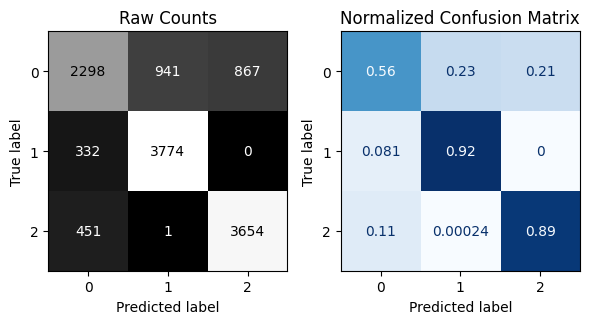

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- DRQSDT12


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import datetime as dt

# Record the start time
start = dt.datetime.now()

knn = KNeighborsClassifier()  # Initialize KNN classifier with default parameters

knn.fit(X_train_sm, y_train_sm)  # Fit the KNN model

# Record the end time and calculate duration
end = dt.datetime.now()
dur_baseline = end - start

evaluate_classification(knn, X_train_sm,y_train_sm, X_test_imputed, y_test)
print(f'Training time was: {dur_baseline}')


## Transform the data with PCA​

In [ ]:
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_sm)
X_test_pca = pca.transform(X_test_imputed)
X_train_pca.head()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- DRQSDT5


In [ ]:
# Record the start time
start = dt.datetime.now()

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca, y_train_sm)

# Record the end time and calc duration
end = dt.datetime.now()
dur_pca = end-start

evaluate_classification(clf, X_train_pca,y_train_sm, X_test_pca, y_test)
print(f'Training time was: {dur_pca}')

NameError: name 'X_test_pca' is not defined

##   Compare Models

In [ ]:
# Compare speeds before and after PCA
compare_speed = dur_baseline/dur_pca
print(f"Using PCs was {compare_speed:.2f} times faster!")

*Q1. How many features were used in the first model, and how many PCs were used in the PCA model?*

*Q2. Which model performed the best on the test set?*

*Q3. Which model was the fastest at making predictions?*